In [1]:
import warnings
warnings.filterwarnings('ignore');

In [2]:
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
################################################################################################
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn import metrics
import os

%matplotlib inline

pd.options.display.max_rows = 100
pd.options.display.max_columns = 100

In [3]:
#reading the data
data = pd.read_csv("train.csv")

In [4]:
#lets look at the number of rows and columns in our dataset
data.shape

(1460, 81)

In [5]:
#lets know what all columns we have in our dataset
data.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

In [6]:
#lets know the dataypes of these columns
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [7]:
#..could see missing values Hence Check for nulls, let get confirmed
df1= data.isnull().sum().sort_values(ascending=False)[data.isnull().sum()>=0]
df1.head(20)

PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
FireplaceQu      690
LotFrontage      259
GarageYrBlt       81
GarageCond        81
GarageType        81
GarageFinish      81
GarageQual        81
BsmtFinType2      38
BsmtExposure      38
BsmtQual          37
BsmtCond          37
BsmtFinType1      37
MasVnrArea         8
MasVnrType         8
Electrical         1
Id                 0
dtype: int64

In [8]:
# As per the data dictionary provided, the NA value/nulls in these columns indicates that a sub attribute is "Not Available"/NA
# which doesnt mean "NO DATA". We need to consider these vlaues which may affect the price.
#Hence, we will impute these categorical variables with 'None' 
for x in ('Alley', 'MasVnrType', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'FireplaceQu', 
            'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence', 'MiscFeature', 'Electrical'):
    data[x]=data[x].fillna('None')

In [9]:
#Drop all columns having more than 85% duplicate values
columns = []
catcols = data.select_dtypes(include=['object'])
for x in catcols :
    max_pct = np.max(catcols[x].value_counts(normalize=True) * 100)
    if (max_pct > 85) :
        columns.append(x)
        
data.drop(columns, axis=1, inplace=True)
data.drop('Id', axis=1, inplace=True) # Dropping ID as its Index column irrelevant for our analysis
data.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,LotShape,LotConfig,Neighborhood,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,Foundation,BsmtQual,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,HeatingQC,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,Fence,MiscVal,MoSold,YrSold,SaleCondition,SalePrice
0,60,RL,65.0,8450,Reg,Inside,CollgCr,1Fam,2Story,7,5,2003,2003,Gable,VinylSd,VinylSd,BrkFace,196.0,Gd,PConc,Gd,No,GLQ,706,0,150,856,Ex,856,854,0,1710,1,0,2,1,3,1,Gd,8,0,None,Attchd,2003.0,RFn,2,548,0,61,0,0,0,0,None,0,2,2008,Normal,208500
1,20,RL,80.0,9600,Reg,FR2,Veenker,1Fam,1Story,6,8,1976,1976,Gable,MetalSd,MetalSd,None,0.0,TA,CBlock,Gd,Gd,ALQ,978,0,284,1262,Ex,1262,0,0,1262,0,1,2,0,3,1,TA,6,1,TA,Attchd,1976.0,RFn,2,460,298,0,0,0,0,0,None,0,5,2007,Normal,181500
2,60,RL,68.0,11250,IR1,Inside,CollgCr,1Fam,2Story,7,5,2001,2002,Gable,VinylSd,VinylSd,BrkFace,162.0,Gd,PConc,Gd,Mn,GLQ,486,0,434,920,Ex,920,866,0,1786,1,0,2,1,3,1,Gd,6,1,TA,Attchd,2001.0,RFn,2,608,0,42,0,0,0,0,None,0,9,2008,Normal,223500
3,70,RL,60.0,9550,IR1,Corner,Crawfor,1Fam,2Story,7,5,1915,1970,Gable,Wd Sdng,Wd Shng,None,0.0,TA,BrkTil,TA,No,ALQ,216,0,540,756,Gd,961,756,0,1717,1,0,1,0,3,1,Gd,7,1,Gd,Detchd,1998.0,Unf,3,642,0,35,272,0,0,0,None,0,2,2006,Abnorml,140000
4,60,RL,84.0,14260,IR1,FR2,NoRidge,1Fam,2Story,8,5,2000,2000,Gable,VinylSd,VinylSd,BrkFace,350.0,Gd,PConc,Gd,Av,GLQ,655,0,490,1145,Ex,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,1,TA,Attchd,2000.0,RFn,3,836,192,84,0,0,0,0,None,0,12,2008,Normal,250000


In [10]:
data.shape

(1460, 59)

In [11]:
#Checking for remaining null values
data[data.columns[data.isna().sum()>0]].isna().sum()

LotFrontage    259
MasVnrArea       8
GarageYrBlt     81
dtype: int64

In [12]:
# Lets check for nulls in categorical columns
data.select_dtypes(include='object').isnull().sum()[data.select_dtypes(include='object').isnull().sum()>0]

Series([], dtype: int64)

In [13]:
# Lets check the null values in the numerical data
data.select_dtypes(include=['int64','float']).isnull().sum()[data.select_dtypes(include=['int64','float']).isnull().sum()>0]

LotFrontage    259
MasVnrArea       8
GarageYrBlt     81
dtype: int64

In [14]:
# Impute the null values with mode values for LotFrontage and MasVnrArea columns
data['LotFrontage'] = data['LotFrontage'].replace(np.nan, data['LotFrontage'].median())
data['MasVnrArea'] = data['MasVnrArea'].replace(np.nan, data['MasVnrArea'].median())

#Assigning values to null value(as per the feature property)
data['GarageYrBlt']=data['GarageYrBlt'].fillna(0)
data['GarageYrBlt'] = data['GarageYrBlt'].astype(int)

##### Now to reduce the number of features, we'll create custom feature which have numeric values and are based on the existing columns
##### Post creation of these features we are of no use with the old ones. Hence, we'll drop them later.

In [15]:
# Create a new column named NewConstruct - This column would determine whether the house has been Newly constructed 
# or not based on the difference between remodelled and built years

def newconstruct(row):
    if(row['YearBuilt'] == row['YearRemodAdd']):
        return 0
    elif(row['YearBuilt'] < row['YearRemodAdd']):
        return 1
    else:
        return 2
    
data['NewConstruct'] = data.apply(newconstruct, axis=1)
data.head(6)   

,MSSubClass,MSZoning,LotFrontage,LotArea,LotShape,LotConfig,Neighborhood,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,Foundation,BsmtQual,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,HeatingQC,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,Fence,MiscVal,MoSold,YrSold,SaleCondition,SalePrice,NewConstruct
0,60,RL,65.0,8450,Reg,Inside,CollgCr,1Fam,2Story,7,5,2003,2003,Gable,VinylSd,VinylSd,BrkFace,196.0,Gd,PConc,Gd,No,GLQ,706,0,150,856,Ex,856,854,0,1710,1,0,2,1,3,1,Gd,8,0,None,Attchd,2003,RFn,2,548,0,61,0,0,0,0,None,0,2,2008,Normal,208500,0
1,20,RL,80.0,9600,Reg,FR2,Veenker,1Fam,1Story,6,8,1976,1976,Gable,MetalSd,MetalSd,None,0.0,TA,CBlock,Gd,Gd,ALQ,978,0,284,1262,Ex,1262,0,0,1262,0,1,2,0,3,1,TA,6,1,TA,Attchd,1976,RFn,2,460,298,0,0,0,0,0,None,0,5,2007,Normal,181500,0
2,60,RL,68.0,11250,IR1,Inside,CollgCr,1Fam,2Story,7,5,2001,2002,Gable,VinylSd,VinylSd,BrkFace,162.0,Gd,PConc,Gd,Mn,GLQ,486,0,434,920,Ex,920,866,0,1786,1,0,2,1,3,1,Gd,6,1,TA,Attchd,2001,RFn,2,608,0,42,0,0,0,0,None,0,9,2008,Normal,223500,1
3,70,RL,60.0,9550,IR1,Corner,Crawfor,1Fam,2Story,7,5,1915,1970,Gable,Wd Sdng,Wd Shng,None,0.0,TA,BrkTil,TA,No,ALQ,216,0,540,756,Gd,961,756,0,1717,1,0,1,0,3,1,Gd,7,1,Gd,Detchd,1998,Unf,3,642,0,35,272,0,0,0,None,0,2,2006,Abnorml,140000,1
4,60,RL,84.0,14260,IR1,FR2,NoRidge,1Fam,2Story,8,5,2000,2000,Gable,VinylSd,VinylSd,BrkFace,350.0,Gd,PConc,Gd,Av,GLQ,655,0,490,1145,Ex,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,1,TA,Attchd,2000,RFn,3,836,192,84,0,0,0,0,None,0,12,2008,Normal,250000,0
5,50,RL,85.0,14115,IR1,Inside,Mitchel,1Fam,1.5Fin,5,5,1993,1995,Gable,VinylSd,VinylSd,None,0.0,TA,Wood,Gd,No,GLQ,732,0,64,796,Ex,796,566,0,1362,1,0,1,1,1,1,TA,5,0,None,Attchd,1993,Unf,2,480,40,30,0,320,0,0,MnPrv,700,10,2009,Normal,143000,1


In [16]:
print(data.shape)
data.head(6)

(1460, 60)


,MSSubClass,MSZoning,LotFrontage,LotArea,LotShape,LotConfig,Neighborhood,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,Foundation,BsmtQual,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,HeatingQC,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,Fence,MiscVal,MoSold,YrSold,SaleCondition,SalePrice,NewConstruct
0,60,RL,65.0,8450,Reg,Inside,CollgCr,1Fam,2Story,7,5,2003,2003,Gable,VinylSd,VinylSd,BrkFace,196.0,Gd,PConc,Gd,No,GLQ,706,0,150,856,Ex,856,854,0,1710,1,0,2,1,3,1,Gd,8,0,None,Attchd,2003,RFn,2,548,0,61,0,0,0,0,None,0,2,2008,Normal,208500,0
1,20,RL,80.0,9600,Reg,FR2,Veenker,1Fam,1Story,6,8,1976,1976,Gable,MetalSd,MetalSd,None,0.0,TA,CBlock,Gd,Gd,ALQ,978,0,284,1262,Ex,1262,0,0,1262,0,1,2,0,3,1,TA,6,1,TA,Attchd,1976,RFn,2,460,298,0,0,0,0,0,None,0,5,2007,Normal,181500,0
2,60,RL,68.0,11250,IR1,Inside,CollgCr,1Fam,2Story,7,5,2001,2002,Gable,VinylSd,VinylSd,BrkFace,162.0,Gd,PConc,Gd,Mn,GLQ,486,0,434,920,Ex,920,866,0,1786,1,0,2,1,3,1,Gd,6,1,TA,Attchd,2001,RFn,2,608,0,42,0,0,0,0,None,0,9,2008,Normal,223500,1
3,70,RL,60.0,9550,IR1,Corner,Crawfor,1Fam,2Story,7,5,1915,1970,Gable,Wd Sdng,Wd Shng,None,0.0,TA,BrkTil,TA,No,ALQ,216,0,540,756,Gd,961,756,0,1717,1,0,1,0,3,1,Gd,7,1,Gd,Detchd,1998,Unf,3,642,0,35,272,0,0,0,None,0,2,2006,Abnorml,140000,1
4,60,RL,84.0,14260,IR1,FR2,NoRidge,1Fam,2Story,8,5,2000,2000,Gable,VinylSd,VinylSd,BrkFace,350.0,Gd,PConc,Gd,Av,GLQ,655,0,490,1145,Ex,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,1,TA,Attchd,2000,RFn,3,836,192,84,0,0,0,0,None,0,12,2008,Normal,250000,0
5,50,RL,85.0,14115,IR1,Inside,Mitchel,1Fam,1.5Fin,5,5,1993,1995,Gable,VinylSd,VinylSd,None,0.0,TA,Wood,Gd,No,GLQ,732,0,64,796,Ex,796,566,0,1362,1,0,1,1,1,1,TA,5,0,None,Attchd,1993,Unf,2,480,40,30,0,320,0,0,MnPrv,700,10,2009,Normal,143000,1


In [17]:
# Create a new column named BuiltOrRemodelledAge and determine the age of the building at the time of selling
def getBuiltOrRemodelAge(row):
    if(row['YearBuilt'] == row['YearRemodAdd']):
        return row['YrSold'] - row['YearBuilt']
    else:
        return row['YrSold'] - row['YearRemodAdd']
       
data['BuiltOrRemodelAge'] = data.apply(getBuiltOrRemodelAge, axis=1)
data.head()  

,MSSubClass,MSZoning,LotFrontage,LotArea,LotShape,LotConfig,Neighborhood,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,Foundation,BsmtQual,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,HeatingQC,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,Fence,MiscVal,MoSold,YrSold,SaleCondition,SalePrice,NewConstruct,BuiltOrRemodelAge
0,60,RL,65.0,8450,Reg,Inside,CollgCr,1Fam,2Story,7,5,2003,2003,Gable,VinylSd,VinylSd,BrkFace,196.0,Gd,PConc,Gd,No,GLQ,706,0,150,856,Ex,856,854,0,1710,1,0,2,1,3,1,Gd,8,0,None,Attchd,2003,RFn,2,548,0,61,0,0,0,0,None,0,2,2008,Normal,208500,0,5
1,20,RL,80.0,9600,Reg,FR2,Veenker,1Fam,1Story,6,8,1976,1976,Gable,MetalSd,MetalSd,None,0.0,TA,CBlock,Gd,Gd,ALQ,978,0,284,1262,Ex,1262,0,0,1262,0,1,2,0,3,1,TA,6,1,TA,Attchd,1976,RFn,2,460,298,0,0,0,0,0,None,0,5,2007,Normal,181500,0,31
2,60,RL,68.0,11250,IR1,Inside,CollgCr,1Fam,2Story,7,5,2001,2002,Gable,VinylSd,VinylSd,BrkFace,162.0,Gd,PConc,Gd,Mn,GLQ,486,0,434,920,Ex,920,866,0,1786,1,0,2,1,3,1,Gd,6,1,TA,Attchd,2001,RFn,2,608,0,42,0,0,0,0,None,0,9,2008,Normal,223500,1,6
3,70,RL,60.0,9550,IR1,Corner,Crawfor,1Fam,2Story,7,5,1915,1970,Gable,Wd Sdng,Wd Shng,None,0.0,TA,BrkTil,TA,No,ALQ,216,0,540,756,Gd,961,756,0,1717,1,0,1,0,3,1,Gd,7,1,Gd,Detchd,1998,Unf,3,642,0,35,272,0,0,0,None,0,2,2006,Abnorml,140000,1,36
4,60,RL,84.0,14260,IR1,FR2,NoRidge,1Fam,2Story,8,5,2000,2000,Gable,VinylSd,VinylSd,BrkFace,350.0,Gd,PConc,Gd,Av,GLQ,655,0,490,1145,Ex,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,1,TA,Attchd,2000,RFn,3,836,192,84,0,0,0,0,None,0,12,2008,Normal,250000,0,8


In [18]:
# Create a new column which would indicate if the Garage is old or new. Since the Garage Year Built less than 2000
# will be considered as old (0) else new(1). For GarageYrBuilt , where we have imputed the value as 0 will also be 
# treated as old.

def getGarageConstructionPeriod(row):
    if row == 0:
        return 0
    elif row >= 1900 and row < 2000:        
        return 0
    else:   
        return 1
    
data['OldOrNewGarage'] = data['GarageYrBlt'].apply(getGarageConstructionPeriod)
data.head() 

,MSSubClass,MSZoning,LotFrontage,LotArea,LotShape,LotConfig,Neighborhood,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,Foundation,BsmtQual,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,HeatingQC,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,Fence,MiscVal,MoSold,YrSold,SaleCondition,SalePrice,NewConstruct,BuiltOrRemodelAge,OldOrNewGarage
0,60,RL,65.0,8450,Reg,Inside,CollgCr,1Fam,2Story,7,5,2003,2003,Gable,VinylSd,VinylSd,BrkFace,196.0,Gd,PConc,Gd,No,GLQ,706,0,150,856,Ex,856,854,0,1710,1,0,2,1,3,1,Gd,8,0,None,Attchd,2003,RFn,2,548,0,61,0,0,0,0,None,0,2,2008,Normal,208500,0,5,1
1,20,RL,80.0,9600,Reg,FR2,Veenker,1Fam,1Story,6,8,1976,1976,Gable,MetalSd,MetalSd,None,0.0,TA,CBlock,Gd,Gd,ALQ,978,0,284,1262,Ex,1262,0,0,1262,0,1,2,0,3,1,TA,6,1,TA,Attchd,1976,RFn,2,460,298,0,0,0,0,0,None,0,5,2007,Normal,181500,0,31,0
2,60,RL,68.0,11250,IR1,Inside,CollgCr,1Fam,2Story,7,5,2001,2002,Gable,VinylSd,VinylSd,BrkFace,162.0,Gd,PConc,Gd,Mn,GLQ,486,0,434,920,Ex,920,866,0,1786,1,0,2,1,3,1,Gd,6,1,TA,Attchd,2001,RFn,2,608,0,42,0,0,0,0,None,0,9,2008,Normal,223500,1,6,1
3,70,RL,60.0,9550,IR1,Corner,Crawfor,1Fam,2Story,7,5,1915,1970,Gable,Wd Sdng,Wd Shng,None,0.0,TA,BrkTil,TA,No,ALQ,216,0,540,756,Gd,961,756,0,1717,1,0,1,0,3,1,Gd,7,1,Gd,Detchd,1998,Unf,3,642,0,35,272,0,0,0,None,0,2,2006,Abnorml,140000,1,36,0
4,60,RL,84.0,14260,IR1,FR2,NoRidge,1Fam,2Story,8,5,2000,2000,Gable,VinylSd,VinylSd,BrkFace,350.0,Gd,PConc,Gd,Av,GLQ,655,0,490,1145,Ex,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,1,TA,Attchd,2000,RFn,3,836,192,84,0,0,0,0,None,0,12,2008,Normal,250000,0,8,1


In [19]:
# Since we have created new features from YearBuilt, YearRemodAdd, YrSold and GarageYrBlt, we can drop these columns as we 
# would only be using the derived columns for further analysis

data.drop(['YearBuilt', 'YearRemodAdd', 'YrSold', 'GarageYrBlt'], axis = 1, inplace = True)

##### Lets now Remove numerical attributes that have more than 85% data associated to one value.
    - 85% of 1460 = ( 0.85x1460 = 1241 ) Hence, We will remove any column that has one value repeating 1241 times.

In [20]:
# Drop the following columns that have more than 85% values associated to a specific value
# We will also drop MoSold as we will not be using that for further analysis

def getHighValueCounts():
    column = []
    numerical_columns = data.select_dtypes(include=['int64', 'float'])
    for x in (numerical_columns):
        if(data[x].value_counts().max() >= 1241):
            column.append(x)
    return column

columnsToBeRemoved = getHighValueCounts()
data.drop(columnsToBeRemoved, axis = 1, inplace = True)

data.drop(['MoSold'], axis = 1, inplace = True)

data.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,LotShape,LotConfig,Neighborhood,BldgType,HouseStyle,OverallQual,OverallCond,RoofStyle,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,Foundation,BsmtQual,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtUnfSF,TotalBsmtSF,HeatingQC,1stFlrSF,2ndFlrSF,GrLivArea,BsmtFullBath,FullBath,HalfBath,BedroomAbvGr,KitchenQual,TotRmsAbvGrd,Fireplaces,FireplaceQu,GarageType,GarageFinish,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,Fence,SaleCondition,SalePrice,NewConstruct,BuiltOrRemodelAge,OldOrNewGarage
0,60,RL,65.0,8450,Reg,Inside,CollgCr,1Fam,2Story,7,5,Gable,VinylSd,VinylSd,BrkFace,196.0,Gd,PConc,Gd,No,GLQ,706,150,856,Ex,856,854,1710,1,2,1,3,Gd,8,0,None,Attchd,RFn,2,548,0,61,None,Normal,208500,0,5,1
1,20,RL,80.0,9600,Reg,FR2,Veenker,1Fam,1Story,6,8,Gable,MetalSd,MetalSd,None,0.0,TA,CBlock,Gd,Gd,ALQ,978,284,1262,Ex,1262,0,1262,0,2,0,3,TA,6,1,TA,Attchd,RFn,2,460,298,0,None,Normal,181500,0,31,0
2,60,RL,68.0,11250,IR1,Inside,CollgCr,1Fam,2Story,7,5,Gable,VinylSd,VinylSd,BrkFace,162.0,Gd,PConc,Gd,Mn,GLQ,486,434,920,Ex,920,866,1786,1,2,1,3,Gd,6,1,TA,Attchd,RFn,2,608,0,42,None,Normal,223500,1,6,1
3,70,RL,60.0,9550,IR1,Corner,Crawfor,1Fam,2Story,7,5,Gable,Wd Sdng,Wd Shng,None,0.0,TA,BrkTil,TA,No,ALQ,216,540,756,Gd,961,756,1717,1,1,0,3,Gd,7,1,Gd,Detchd,Unf,3,642,0,35,None,Abnorml,140000,1,36,0
4,60,RL,84.0,14260,IR1,FR2,NoRidge,1Fam,2Story,8,5,Gable,VinylSd,VinylSd,BrkFace,350.0,Gd,PConc,Gd,Av,GLQ,655,490,1145,Ex,1145,1053,2198,1,2,1,4,Gd,9,1,TA,Attchd,RFn,3,836,192,84,None,Normal,250000,0,8,1


In [21]:
print(data.shape)
data.head(6)

(1460, 48)


,MSSubClass,MSZoning,LotFrontage,LotArea,LotShape,LotConfig,Neighborhood,BldgType,HouseStyle,OverallQual,OverallCond,RoofStyle,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,Foundation,BsmtQual,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtUnfSF,TotalBsmtSF,HeatingQC,1stFlrSF,2ndFlrSF,GrLivArea,BsmtFullBath,FullBath,HalfBath,BedroomAbvGr,KitchenQual,TotRmsAbvGrd,Fireplaces,FireplaceQu,GarageType,GarageFinish,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,Fence,SaleCondition,SalePrice,NewConstruct,BuiltOrRemodelAge,OldOrNewGarage
0,60,RL,65.0,8450,Reg,Inside,CollgCr,1Fam,2Story,7,5,Gable,VinylSd,VinylSd,BrkFace,196.0,Gd,PConc,Gd,No,GLQ,706,150,856,Ex,856,854,1710,1,2,1,3,Gd,8,0,None,Attchd,RFn,2,548,0,61,None,Normal,208500,0,5,1
1,20,RL,80.0,9600,Reg,FR2,Veenker,1Fam,1Story,6,8,Gable,MetalSd,MetalSd,None,0.0,TA,CBlock,Gd,Gd,ALQ,978,284,1262,Ex,1262,0,1262,0,2,0,3,TA,6,1,TA,Attchd,RFn,2,460,298,0,None,Normal,181500,0,31,0
2,60,RL,68.0,11250,IR1,Inside,CollgCr,1Fam,2Story,7,5,Gable,VinylSd,VinylSd,BrkFace,162.0,Gd,PConc,Gd,Mn,GLQ,486,434,920,Ex,920,866,1786,1,2,1,3,Gd,6,1,TA,Attchd,RFn,2,608,0,42,None,Normal,223500,1,6,1
3,70,RL,60.0,9550,IR1,Corner,Crawfor,1Fam,2Story,7,5,Gable,Wd Sdng,Wd Shng,None,0.0,TA,BrkTil,TA,No,ALQ,216,540,756,Gd,961,756,1717,1,1,0,3,Gd,7,1,Gd,Detchd,Unf,3,642,0,35,None,Abnorml,140000,1,36,0
4,60,RL,84.0,14260,IR1,FR2,NoRidge,1Fam,2Story,8,5,Gable,VinylSd,VinylSd,BrkFace,350.0,Gd,PConc,Gd,Av,GLQ,655,490,1145,Ex,1145,1053,2198,1,2,1,4,Gd,9,1,TA,Attchd,RFn,3,836,192,84,None,Normal,250000,0,8,1
5,50,RL,85.0,14115,IR1,Inside,Mitchel,1Fam,1.5Fin,5,5,Gable,VinylSd,VinylSd,None,0.0,TA,Wood,Gd,No,GLQ,732,64,796,Ex,796,566,1362,1,1,1,1,TA,5,0,None,Attchd,Unf,2,480,40,30,MnPrv,Normal,143000,1,14,0


In [22]:
# Now Lets once again check for percentage of null values in each column
percent_missing = round(100*(data.isnull().sum()/len(data.index)), 2)
print(percent_missing)

MSSubClass           0.0
MSZoning             0.0
LotFrontage          0.0
LotArea              0.0
LotShape             0.0
LotConfig            0.0
Neighborhood         0.0
BldgType             0.0
HouseStyle           0.0
OverallQual          0.0
OverallCond          0.0
RoofStyle            0.0
Exterior1st          0.0
Exterior2nd          0.0
MasVnrType           0.0
MasVnrArea           0.0
ExterQual            0.0
Foundation           0.0
BsmtQual             0.0
BsmtExposure         0.0
BsmtFinType1         0.0
BsmtFinSF1           0.0
BsmtUnfSF            0.0
TotalBsmtSF          0.0
HeatingQC            0.0
1stFlrSF             0.0
2ndFlrSF             0.0
GrLivArea            0.0
BsmtFullBath         0.0
FullBath             0.0
HalfBath             0.0
BedroomAbvGr         0.0
KitchenQual          0.0
TotRmsAbvGrd         0.0
Fireplaces           0.0
FireplaceQu          0.0
GarageType           0.0
GarageFinish         0.0
GarageCars           0.0
GarageArea           0.0


In [23]:
# Similarly letc Check for Duplicates
# Check if there are any duplicate values in the dataset
data[data.duplicated(keep=False)]

,MSSubClass,MSZoning,LotFrontage,LotArea,LotShape,LotConfig,Neighborhood,BldgType,HouseStyle,OverallQual,OverallCond,RoofStyle,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,Foundation,BsmtQual,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtUnfSF,TotalBsmtSF,HeatingQC,1stFlrSF,2ndFlrSF,GrLivArea,BsmtFullBath,FullBath,HalfBath,BedroomAbvGr,KitchenQual,TotRmsAbvGrd,Fireplaces,FireplaceQu,GarageType,GarageFinish,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,Fence,SaleCondition,SalePrice,NewConstruct,BuiltOrRemodelAge,OldOrNewGarage


In [24]:
#### Outlier Treatment
# Checking outliers at 25%,50%,75%,90%,95% and above
data.describe(percentiles=[.25,.5,.75,.90,.95,.99])

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,MasVnrArea,BsmtFinSF1,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,GrLivArea,BsmtFullBath,FullBath,HalfBath,BedroomAbvGr,TotRmsAbvGrd,Fireplaces,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,SalePrice,NewConstruct,BuiltOrRemodelAge,OldOrNewGarage
count,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,56.897260,69.863699,10516.828082,6.099315,5.575342,103.117123,443.639726,567.240411,1057.429452,1162.626712,346.992466,1515.463699,0.425342,1.565068,0.382877,2.866438,6.517808,0.613014,1.767123,472.980137,94.244521,46.660274,180921.195890,0.476712,22.950000,0.275342
std,42.300571,22.027677,9981.264932,1.382997,1.112799,180.731373,456.098091,441.866955,438.705324,386.587738,436.528436,525.480383,0.518911,0.550916,0.502885,0.815778,1.625393,0.644666,0.747315,213.804841,125.338794,66.256028,79442.502883,0.499629,20.640653,0.446840
min,20.000000,21.000000,1300.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,334.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,34900.000000,0.000000,-1.000000,0.000000
25%,20.000000,60.000000,7553.500000,5.000000,5.000000,0.000000,0.000000,223.000000,795.750000,882.000000,0.000000,1129.500000,0.000000,1.000000,0.000000,2.000000,5.000000,0.000000,1.000000,334.500000,0.000000,0.000000,129975.000000,0.000000,4.000000,0.000000
50%,50.000000,69.000000,9478.500000,6.000000,5.000000,0.000000,383.500000,477.500000,991.500000,1087.000000,0.000000,1464.000000,0.000000,2.000000,0.000000,3.000000,6.000000,1.000000,2.000000,480.000000,0.000000,25.000000,163000.000000,0.000000,14.000000,0.000000
75%,70.000000,79.000000,11601.500000,7.000000,6.000000,164.250000,712.250000,808.000000,1298.250000,1391.250000,728.000000,1776.750000,1.000000,2.000000,1.000000,3.000000,7.000000,1.000000,2.000000,576.000000,168.000000,68.000000,214000.000000,1.000000,41.000000,1.000000
90%,120.000000,92.000000,14381.700000,8.000000,7.000000,335.000000,1065.500000,1232.000000,1602.200000,1680.000000,954.200000,2158.300000,1.000000,2.000000,1.000000,4.000000,9.000000,1.000000,3.000000,757.100000,262.000000,130.000000,278000.000000,1.000000,56.000000,1.000000
95%,160.000000,104.000000,17401.150000,8.000000,8.000000,456.000000,1274.000000,1468.000000,1753.000000,1831.250000,1141.050000,2466.100000,1.000000,2.000000,1.000000,4.000000,10.000000,2.000000,3.000000,850.100000,335.000000,175.050000,326100.000000,1.000000,58.000000,1.000000
99%,190.000000,137.410000,37567.640000,10.000000,9.000000,791.280000,1572.410000,1797.050000,2155.050000,2219.460000,1418.920000,3123.480000,2.000000,3.000000,1.000000,5.000000,11.000000,2.000000,3.000000,1002.790000,505.460000,285.820000,442567.010000,1.000000,60.000000,1.000000


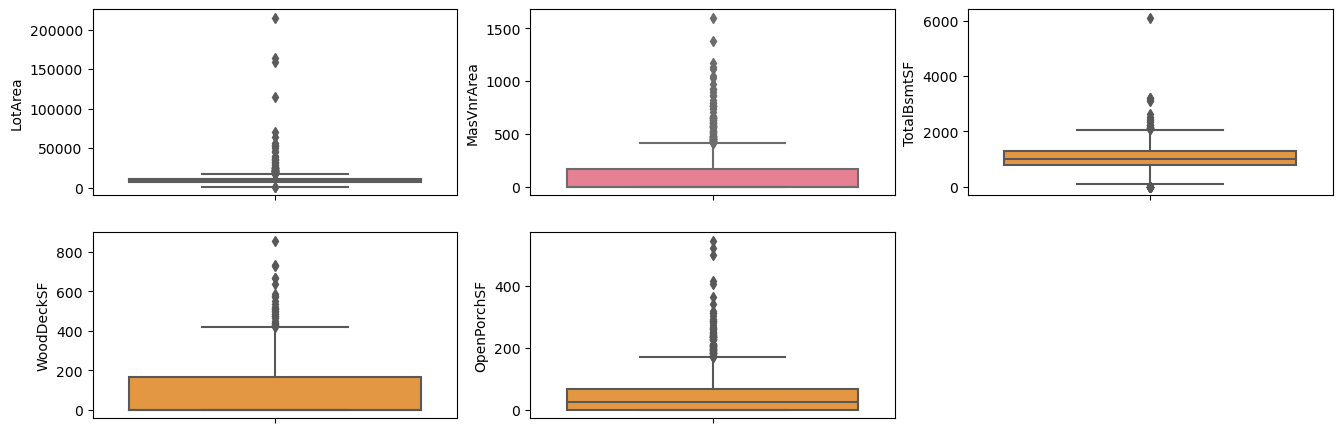

In [25]:
# Check the outliers in all the numeric columns
plt.figure(figsize=(16,14))
plt.subplot(5,3,1)
sns.boxplot(y = 'LotArea', palette='hls', data = data)
plt.subplot(5,3,2)
sns.boxplot(y = 'MasVnrArea', palette='husl', data = data)
plt.subplot(5,3,3)
sns.boxplot(y = 'TotalBsmtSF', palette='YlOrBr', data = data)
plt.subplot(5,3,4)
sns.boxplot(y = 'WoodDeckSF', palette='YlOrBr', data = data)
plt.subplot(5,3,5)
sns.boxplot(y = 'OpenPorchSF', palette='YlOrBr', data = data)
plt.show()

In [26]:
#Now let remove the outliers in our data columns.
# Removing values beyond 98% for LotArea
nn_quartile_LotArea = data['LotArea'].quantile(0.98)
data = data[data["LotArea"] < nn_quartile_LotArea]
# Removing values beyond 98% for MasVnrArea
nn_quartile_MasVnrArea = data['MasVnrArea'].quantile(0.98)
data = data[data["MasVnrArea"] < nn_quartile_MasVnrArea]
# Removing values beyond 99% for TotalBsmtSF
nn_quartile_TotalBsmtSF = data['TotalBsmtSF'].quantile(0.99)
data = data[data["TotalBsmtSF"] < nn_quartile_TotalBsmtSF]
# Removing values beyond 99% for WoodDeckSF
nn_quartile_WoodDeckSF = data['WoodDeckSF'].quantile(0.99)
data = data[data["WoodDeckSF"] < nn_quartile_WoodDeckSF]
# Removing values beyond 99% for OpenPorchSF
nn_quartile_OpenPorchSF = data['OpenPorchSF'].quantile(0.99)
data = data[data["OpenPorchSF"] < nn_quartile_OpenPorchSF]

In [27]:
#Now lets check what percentage of data we are left with after removing outlier
data_prct = round(100*(len(data)/1460),2)
print(data_prct)

93.01


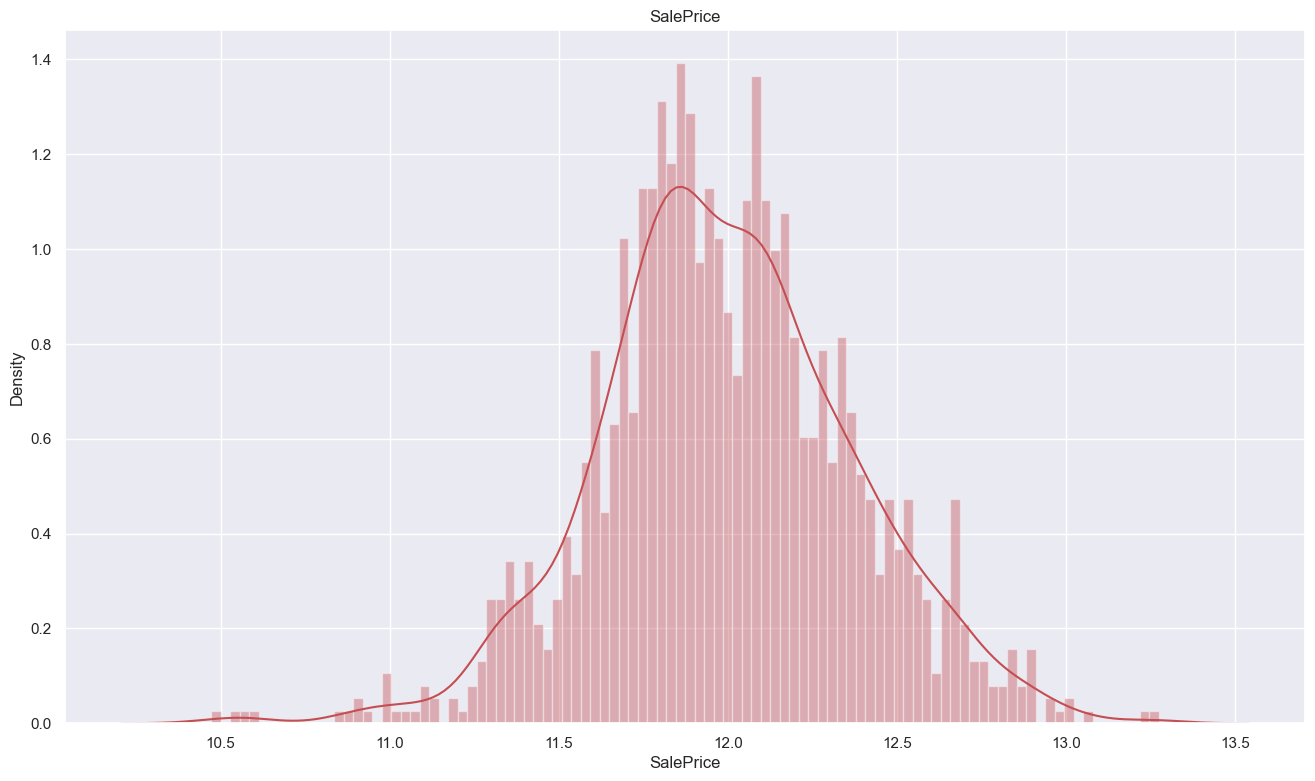

In [28]:
## Step 3: Data Visualization 
# Visualise the target variable -> SalePrice after transforming the sales price
data['SalePrice'] = np.log1p(data['SalePrice'])
plt.figure(figsize=(16,9)) # figure ration 16:9
sns.set()
plt.title('SalePrice')
sns.distplot(data['SalePrice'],norm_hist=True, bins=100, color='r')
plt.show()

<Figure size 600x500 with 0 Axes>

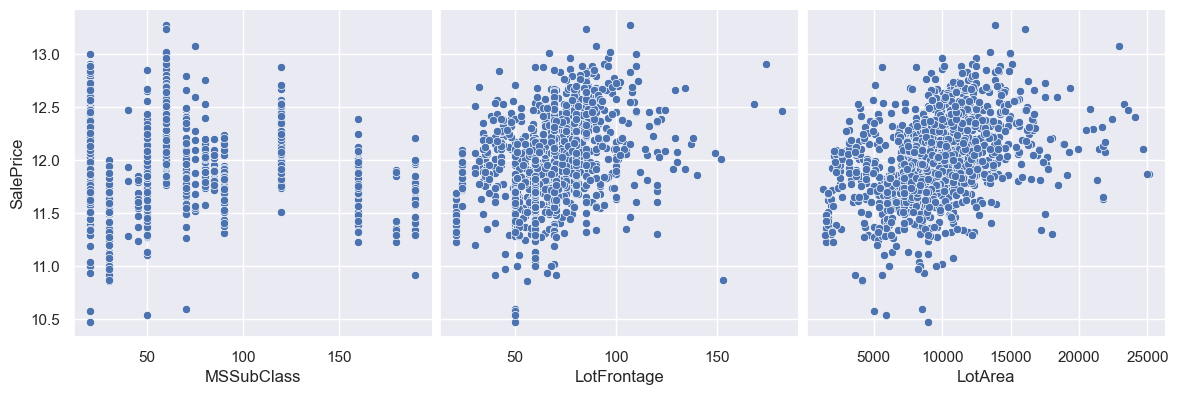

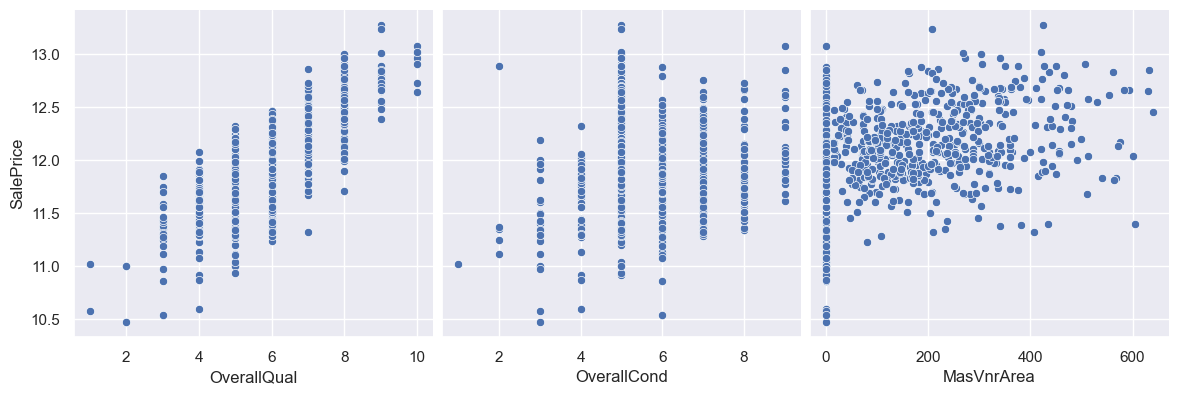

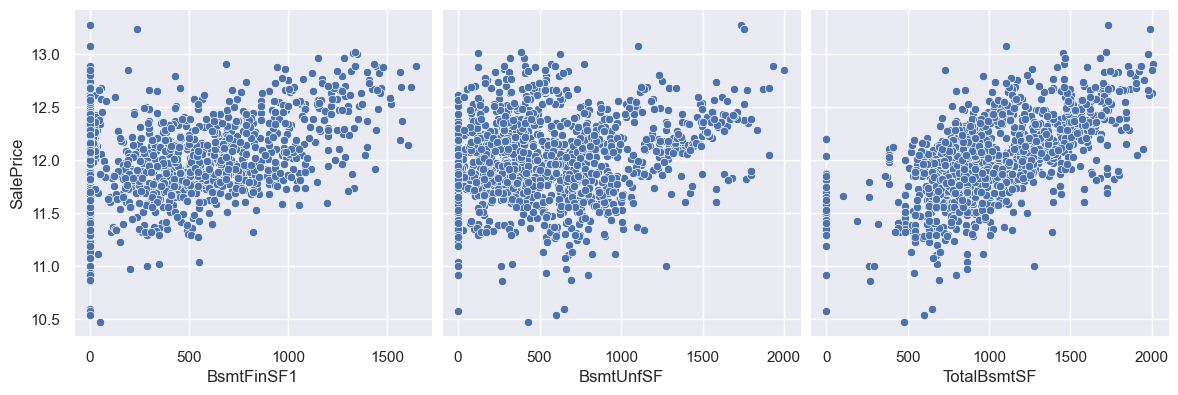

In [29]:
plt.figure(figsize=(6,5))
sns.pairplot(data, x_vars=['MSSubClass','LotFrontage','LotArea'], y_vars='SalePrice',height=4, aspect=1)#,kind='scatter')
sns.pairplot(data, x_vars=['OverallQual', 'OverallCond','MasVnrArea'], y_vars='SalePrice',height=4, aspect=1)#,kind='scatter')
sns.pairplot(data, x_vars=['BsmtFinSF1', 'BsmtUnfSF','TotalBsmtSF'], y_vars='SalePrice',height=4, aspect=1)#,kind='scatter')
plt.show()

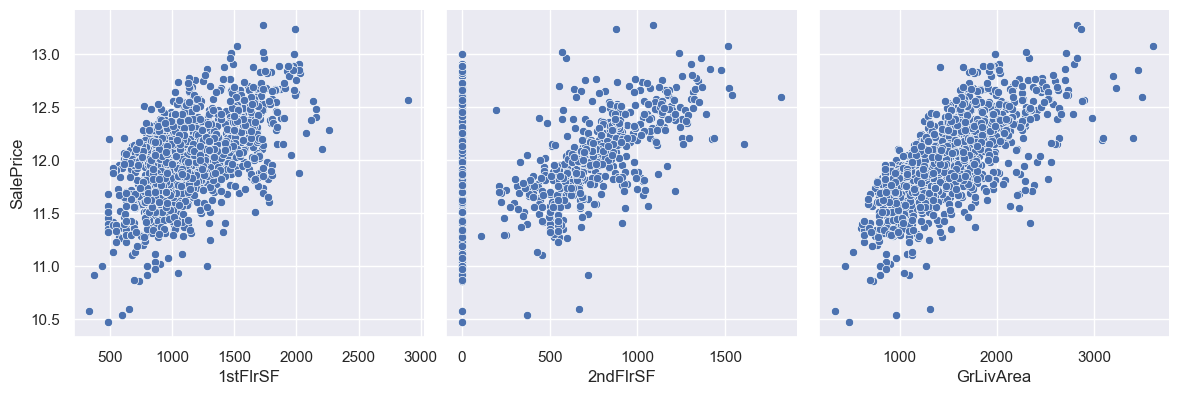

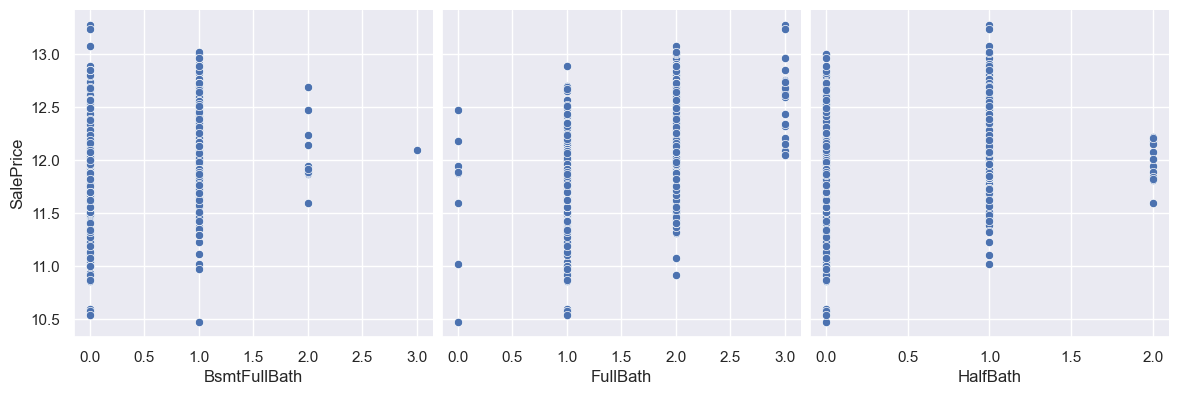

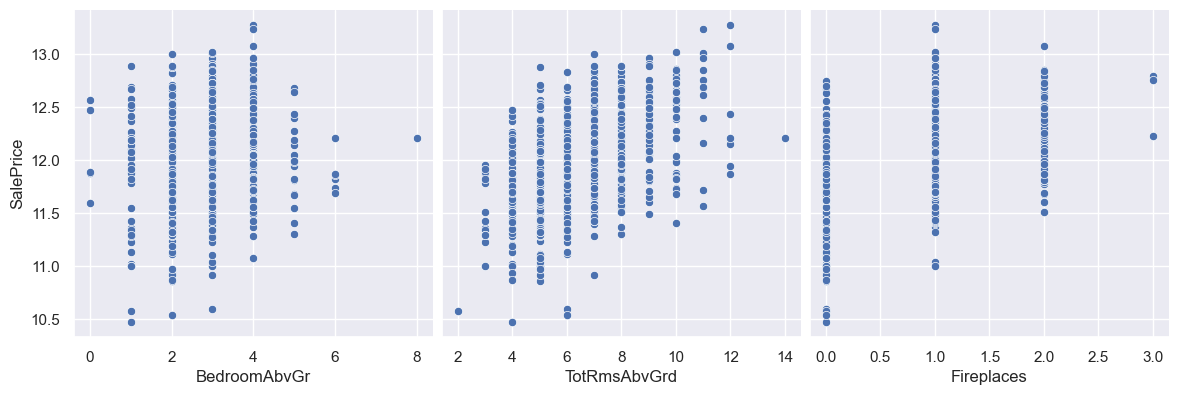

In [30]:
sns.pairplot(data, x_vars=['1stFlrSF','2ndFlrSF', 'GrLivArea'], y_vars='SalePrice',height=4, aspect=1,kind='scatter')
sns.pairplot(data, x_vars=['BsmtFullBath','FullBath', 'HalfBath'], y_vars='SalePrice',height=4, aspect=1,kind='scatter')
sns.pairplot(data, x_vars=['BedroomAbvGr','TotRmsAbvGrd', 'Fireplaces'], y_vars='SalePrice',height=4, aspect=1,kind='scatter')

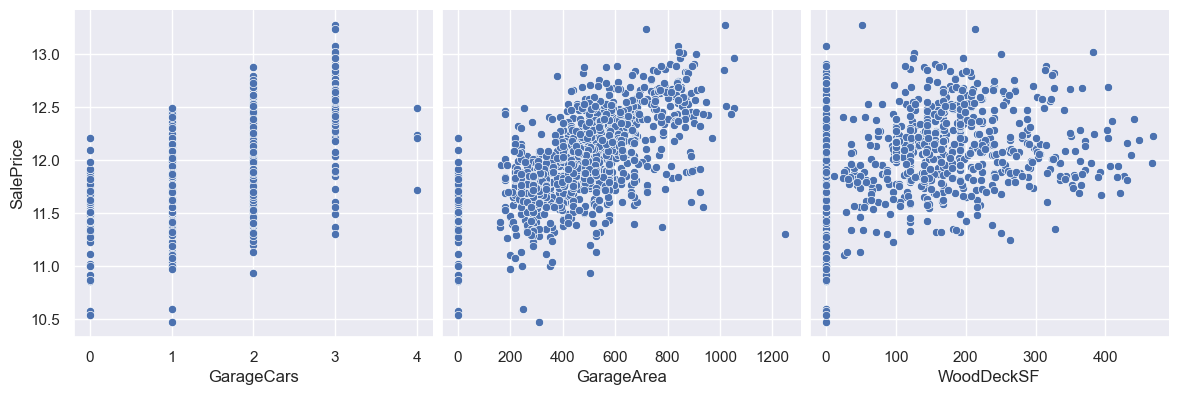

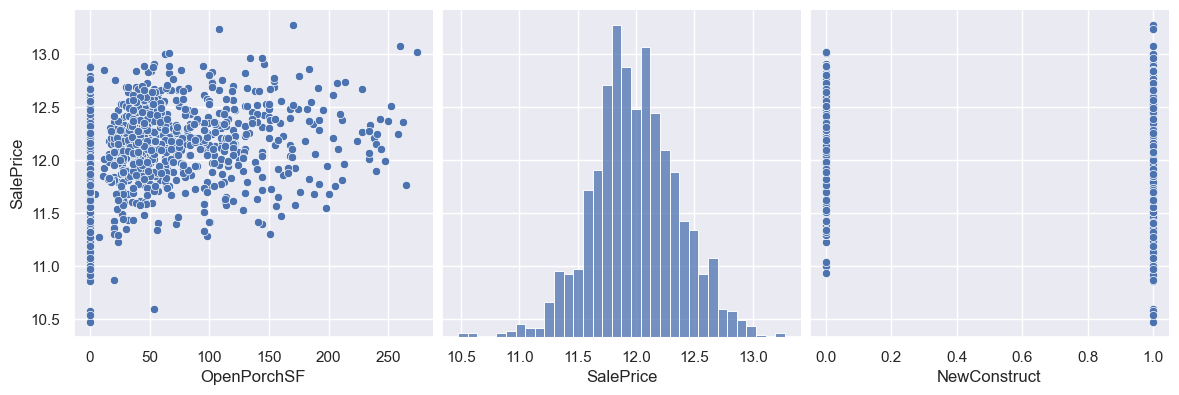

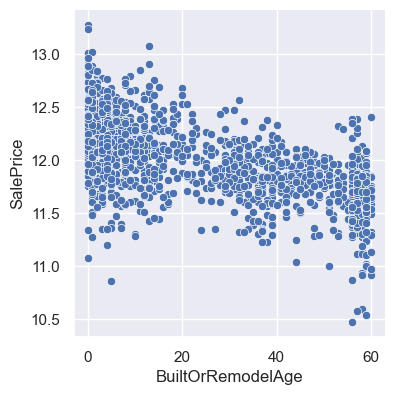

In [31]:
sns.pairplot(data, x_vars=['GarageCars','GarageArea', 'WoodDeckSF'], y_vars='SalePrice',height=4, aspect=1,kind='scatter')
sns.pairplot(data, x_vars=['OpenPorchSF','SalePrice', 'NewConstruct'], y_vars='SalePrice',height=4, aspect=1,kind='scatter')
sns.pairplot(data, x_vars=['BuiltOrRemodelAge'], y_vars='SalePrice',height=4, aspect=1,kind='scatter')
plt.show()

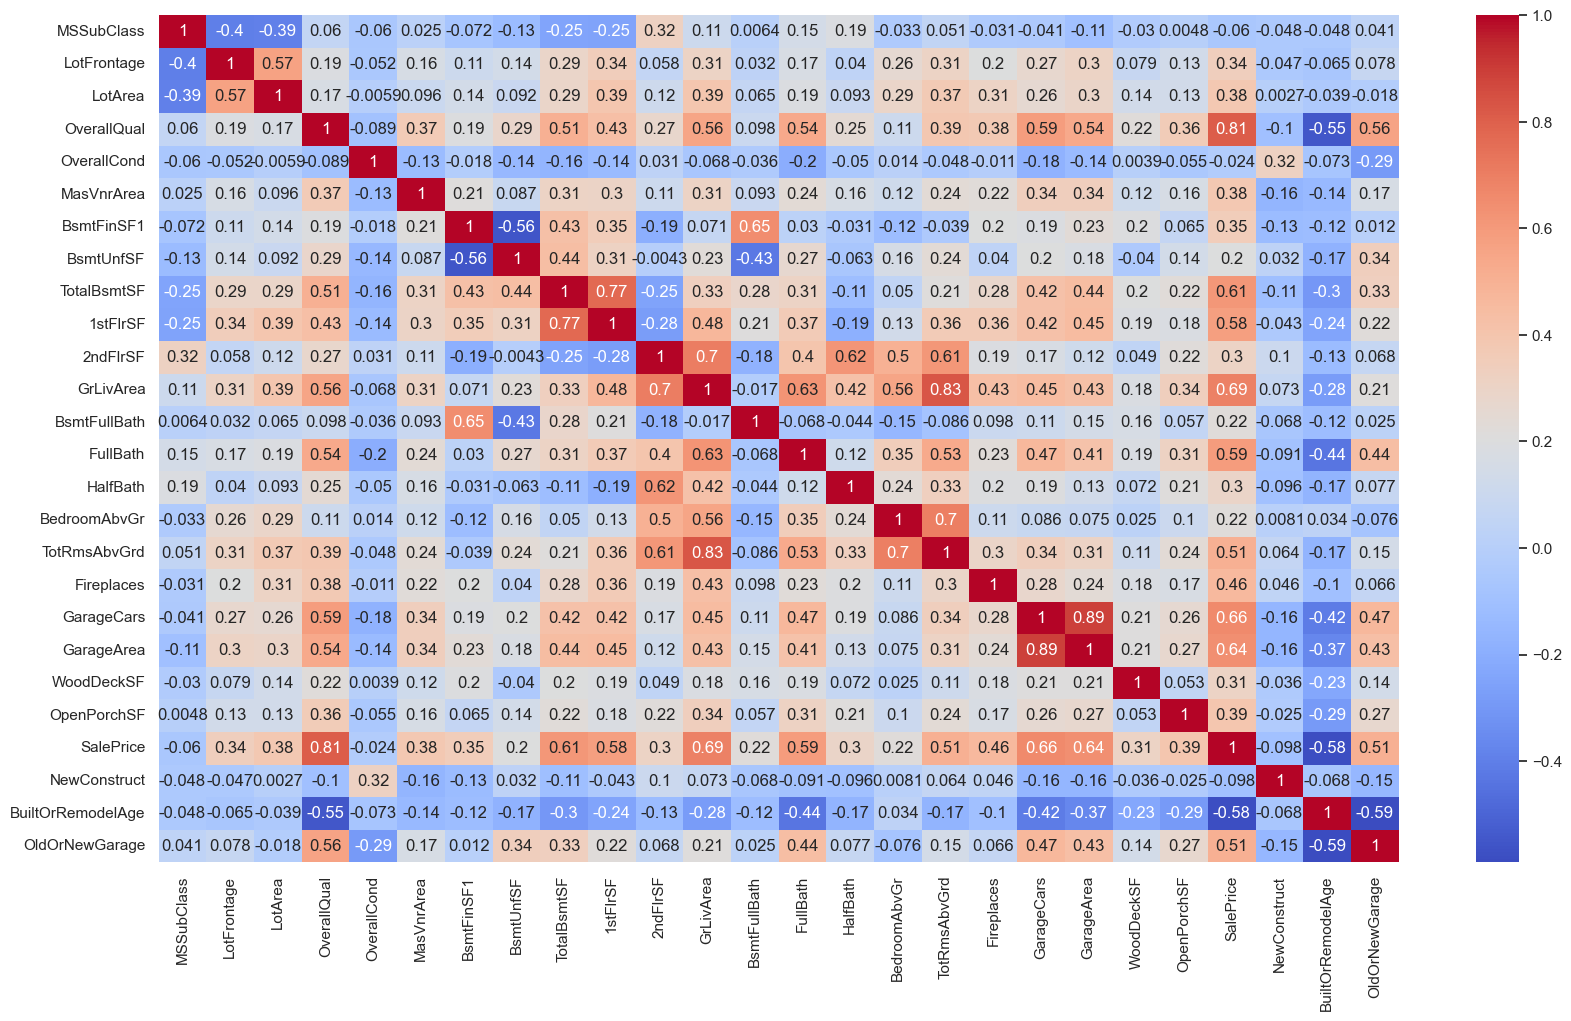

In [32]:
# Check the correlation of numerical columns
plt.figure(figsize = (20, 11))
sns.heatmap(data.corr(), annot = True, cmap="coolwarm")
plt.show()

In [33]:
# Removing the highly correlated variables
data.drop(['TotRmsAbvGrd', 'GarageArea'], axis = 1, inplace = True)

In [34]:
# Check the shape of the dataframe
data.shape

(1358, 46)

In [35]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1358 entries, 0 to 1458
Data columns (total 46 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   MSSubClass         1358 non-null   int64  
 1   MSZoning           1358 non-null   object 
 2   LotFrontage        1358 non-null   float64
 3   LotArea            1358 non-null   int64  
 4   LotShape           1358 non-null   object 
 5   LotConfig          1358 non-null   object 
 6   Neighborhood       1358 non-null   object 
 7   BldgType           1358 non-null   object 
 8   HouseStyle         1358 non-null   object 
 9   OverallQual        1358 non-null   int64  
 10  OverallCond        1358 non-null   int64  
 11  RoofStyle          1358 non-null   object 
 12  Exterior1st        1358 non-null   object 
 13  Exterior2nd        1358 non-null   object 
 14  MasVnrType         1358 non-null   object 
 15  MasVnrArea         1358 non-null   float64
 16  ExterQual          1358 

In [36]:
data.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,LotShape,LotConfig,Neighborhood,BldgType,HouseStyle,OverallQual,OverallCond,RoofStyle,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,Foundation,BsmtQual,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtUnfSF,TotalBsmtSF,HeatingQC,1stFlrSF,2ndFlrSF,GrLivArea,BsmtFullBath,FullBath,HalfBath,BedroomAbvGr,KitchenQual,Fireplaces,FireplaceQu,GarageType,GarageFinish,GarageCars,WoodDeckSF,OpenPorchSF,Fence,SaleCondition,SalePrice,NewConstruct,BuiltOrRemodelAge,OldOrNewGarage
0,60,RL,65.0,8450,Reg,Inside,CollgCr,1Fam,2Story,7,5,Gable,VinylSd,VinylSd,BrkFace,196.0,Gd,PConc,Gd,No,GLQ,706,150,856,Ex,856,854,1710,1,2,1,3,Gd,0,None,Attchd,RFn,2,0,61,None,Normal,12.247699,0,5,1
1,20,RL,80.0,9600,Reg,FR2,Veenker,1Fam,1Story,6,8,Gable,MetalSd,MetalSd,None,0.0,TA,CBlock,Gd,Gd,ALQ,978,284,1262,Ex,1262,0,1262,0,2,0,3,TA,1,TA,Attchd,RFn,2,298,0,None,Normal,12.109016,0,31,0
2,60,RL,68.0,11250,IR1,Inside,CollgCr,1Fam,2Story,7,5,Gable,VinylSd,VinylSd,BrkFace,162.0,Gd,PConc,Gd,Mn,GLQ,486,434,920,Ex,920,866,1786,1,2,1,3,Gd,1,TA,Attchd,RFn,2,0,42,None,Normal,12.317171,1,6,1
3,70,RL,60.0,9550,IR1,Corner,Crawfor,1Fam,2Story,7,5,Gable,Wd Sdng,Wd Shng,None,0.0,TA,BrkTil,TA,No,ALQ,216,540,756,Gd,961,756,1717,1,1,0,3,Gd,1,Gd,Detchd,Unf,3,0,35,None,Abnorml,11.849405,1,36,0
4,60,RL,84.0,14260,IR1,FR2,NoRidge,1Fam,2Story,8,5,Gable,VinylSd,VinylSd,BrkFace,350.0,Gd,PConc,Gd,Av,GLQ,655,490,1145,Ex,1145,1053,2198,1,2,1,4,Gd,1,TA,Attchd,RFn,3,192,84,None,Normal,12.429220,0,8,1


In [37]:
#Converting Categorical numerical variables to object type
data['MSSubClass']=data['MSSubClass'].astype('object')
data['OverallQual']=data['OverallQual'].astype('object')
data['OverallCond']=data['OverallCond'].astype('object')
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1358 entries, 0 to 1458
Data columns (total 46 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   MSSubClass         1358 non-null   object 
 1   MSZoning           1358 non-null   object 
 2   LotFrontage        1358 non-null   float64
 3   LotArea            1358 non-null   int64  
 4   LotShape           1358 non-null   object 
 5   LotConfig          1358 non-null   object 
 6   Neighborhood       1358 non-null   object 
 7   BldgType           1358 non-null   object 
 8   HouseStyle         1358 non-null   object 
 9   OverallQual        1358 non-null   object 
 10  OverallCond        1358 non-null   object 
 11  RoofStyle          1358 non-null   object 
 12  Exterior1st        1358 non-null   object 
 13  Exterior2nd        1358 non-null   object 
 14  MasVnrType         1358 non-null   object 
 15  MasVnrArea         1358 non-null   float64
 16  ExterQual          1358 

In [38]:
#Getting all the categorical variables
X=data
data_categorical=X.select_dtypes(include=['object'])
data_categorical.head()

,MSSubClass,MSZoning,LotShape,LotConfig,Neighborhood,BldgType,HouseStyle,OverallQual,OverallCond,RoofStyle,Exterior1st,Exterior2nd,MasVnrType,ExterQual,Foundation,BsmtQual,BsmtExposure,BsmtFinType1,HeatingQC,KitchenQual,FireplaceQu,GarageType,GarageFinish,Fence,SaleCondition
0,60,RL,Reg,Inside,CollgCr,1Fam,2Story,7,5,Gable,VinylSd,VinylSd,BrkFace,Gd,PConc,Gd,No,GLQ,Ex,Gd,None,Attchd,RFn,None,Normal
1,20,RL,Reg,FR2,Veenker,1Fam,1Story,6,8,Gable,MetalSd,MetalSd,None,TA,CBlock,Gd,Gd,ALQ,Ex,TA,TA,Attchd,RFn,None,Normal
2,60,RL,IR1,Inside,CollgCr,1Fam,2Story,7,5,Gable,VinylSd,VinylSd,BrkFace,Gd,PConc,Gd,Mn,GLQ,Ex,Gd,TA,Attchd,RFn,None,Normal
3,70,RL,IR1,Corner,Crawfor,1Fam,2Story,7,5,Gable,Wd Sdng,Wd Shng,None,TA,BrkTil,TA,No,ALQ,Gd,Gd,Gd,Detchd,Unf,None,Abnorml
4,60,RL,IR1,FR2,NoRidge,1Fam,2Story,8,5,Gable,VinylSd,VinylSd,BrkFace,Gd,PConc,Gd,Av,GLQ,Ex,Gd,TA,Attchd,RFn,None,Normal


In [39]:
#Creating Dummy variables
data_dummies=pd.get_dummies(data_categorical, drop_first=True)
data_dummies

,MSSubClass_30,MSSubClass_40,MSSubClass_45,MSSubClass_50,MSSubClass_60,MSSubClass_70,MSSubClass_75,MSSubClass_80,MSSubClass_85,MSSubClass_90,MSSubClass_120,MSSubClass_160,MSSubClass_180,MSSubClass_190,MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,LotShape_IR2,LotShape_IR3,LotShape_Reg,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,BldgType_2fmCon,...,ExterQual_TA,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,BsmtQual_Fa,BsmtQual_Gd,BsmtQual_None,BsmtQual_TA,BsmtExposure_Gd,BsmtExposure_Mn,BsmtExposure_No,BsmtExposure_None,BsmtFinType1_BLQ,BsmtFinType1_GLQ,BsmtFinType1_LwQ,BsmtFinType1_None,BsmtFinType1_Rec,BsmtFinType1_Unf,HeatingQC_Fa,HeatingQC_Gd,HeatingQC_Po,HeatingQC_TA,KitchenQual_Fa,KitchenQual_Gd,KitchenQual_TA,FireplaceQu_Fa,FireplaceQu_Gd,FireplaceQu_None,FireplaceQu_Po,FireplaceQu_TA,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageType_None,GarageFinish_None,GarageFinish_RFn,GarageFinish_Unf,Fence_GdWo,Fence_MnPrv,Fence_MnWw,Fence_None,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,...,1,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0
2,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0
3,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0
4,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,...,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0
1455,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0
1456,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,...,1,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0
1457,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0


In [40]:
#Dropping categorical variables
X=X.drop(list(data_categorical.columns),axis=1)

In [41]:
#Adding Dummy variables
X=pd.concat([X,data_dummies],axis=1)

In [42]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1358 entries, 0 to 1458
Columns: 187 entries, LotFrontage to SaleCondition_Partial
dtypes: float64(3), int64(18), uint8(166)
memory usage: 453.6 KB


##### Train Test Split and MinMAxScaling


In [43]:
#Splitting training and test data
from sklearn.model_selection import train_test_split
np.random.seed(0)
train, test = train_test_split(X,train_size=0.7, random_state=42)

In [44]:
#Scaling the dataset using MinMaxScaling
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler()

cols=train.columns
train[cols]=scaler.fit_transform(train[cols])
train.head()

,LotFrontage,LotArea,MasVnrArea,BsmtFinSF1,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,GrLivArea,BsmtFullBath,FullBath,HalfBath,BedroomAbvGr,Fireplaces,GarageCars,WoodDeckSF,OpenPorchSF,SalePrice,NewConstruct,BuiltOrRemodelAge,OldOrNewGarage,MSSubClass_30,MSSubClass_40,MSSubClass_45,MSSubClass_50,MSSubClass_60,MSSubClass_70,MSSubClass_75,MSSubClass_80,MSSubClass_85,MSSubClass_90,MSSubClass_120,MSSubClass_160,MSSubClass_180,MSSubClass_190,MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,LotShape_IR2,LotShape_IR3,LotShape_Reg,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,...,ExterQual_TA,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,BsmtQual_Fa,BsmtQual_Gd,BsmtQual_None,BsmtQual_TA,BsmtExposure_Gd,BsmtExposure_Mn,BsmtExposure_No,BsmtExposure_None,BsmtFinType1_BLQ,BsmtFinType1_GLQ,BsmtFinType1_LwQ,BsmtFinType1_None,BsmtFinType1_Rec,BsmtFinType1_Unf,HeatingQC_Fa,HeatingQC_Gd,HeatingQC_Po,HeatingQC_TA,KitchenQual_Fa,KitchenQual_Gd,KitchenQual_TA,FireplaceQu_Fa,FireplaceQu_Gd,FireplaceQu_None,FireplaceQu_Po,FireplaceQu_TA,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageType_None,GarageFinish_None,GarageFinish_RFn,GarageFinish_Unf,Fence_GdWo,Fence_MnPrv,Fence_MnWw,Fence_None,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
351,0.298137,0.169831,0.000000,0.657351,0.185315,0.724327,0.436427,0.000000,0.341784,0.333333,0.333333,0.5,0.250,0.333333,0.50,0.000000,0.291971,0.584309,0.0,0.333333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1118,0.397516,0.535668,0.000000,0.000000,0.266234,0.265703,0.267941,0.376623,0.386988,0.000000,0.333333,0.0,0.375,0.000000,0.25,0.598291,0.124088,0.471072,1.0,0.350000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
339,0.279503,0.474724,0.275000,0.355407,0.314685,0.605683,0.343604,0.000000,0.269090,0.000000,0.333333,0.0,0.375,0.000000,0.25,0.000000,0.000000,0.508814,1.0,0.183333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1126,0.198758,0.101959,0.203125,0.000000,0.685814,0.684447,0.476209,0.000000,0.372938,0.000000,0.666667,0.0,0.250,0.333333,0.75,0.305556,0.072993,0.551690,0.0,0.033333,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
88,0.521739,0.306646,0.000000,0.000000,0.505994,0.504985,0.264821,0.000000,0.364081,0.000000,0.333333,0.0,0.250,0.000000,0.00,0.000000,0.000000,0.286045,1.0,0.450000,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [45]:
# Popping out our target variable
y_train=train.pop('SalePrice')
X_train=train

print(X_train.shape)

(950, 186)


##### Model Building and Evaluation

In [46]:
### Now lets perform Linear Regression
from sklearn.feature_selection import RFE
#Applying Simple Linear Regression
lm=LinearRegression()
lm.fit(X_train, y_train)

# Out of 185 features we are Fetching 50 features using RFE
rfe=RFE(lm,n_features_to_select=50)
rfe=rfe.fit(X_train,y_train)

In [47]:
#List of columns with rfe rank
list(zip(X_train.columns,rfe.support_,rfe.ranking_))

[('LotFrontage', False, 45),
 ('LotArea', True, 1),
 ('MasVnrArea', False, 104),
 ('BsmtFinSF1', True, 1),
 ('BsmtUnfSF', False, 61),
 ('TotalBsmtSF', True, 1),
 ('1stFlrSF', False, 75),
 ('2ndFlrSF', False, 20),
 ('GrLivArea', True, 1),
 ('BsmtFullBath', False, 7),
 ('FullBath', True, 1),
 ('HalfBath', True, 1),
 ('BedroomAbvGr', False, 15),
 ('Fireplaces', False, 11),
 ('GarageCars', True, 1),
 ('WoodDeckSF', False, 38),
 ('OpenPorchSF', False, 122),
 ('NewConstruct', False, 76),
 ('BuiltOrRemodelAge', True, 1),
 ('OldOrNewGarage', False, 44),
 ('MSSubClass_30', True, 1),
 ('MSSubClass_40', False, 10),
 ('MSSubClass_45', False, 125),
 ('MSSubClass_50', False, 132),
 ('MSSubClass_60', False, 30),
 ('MSSubClass_70', False, 87),
 ('MSSubClass_75', True, 1),
 ('MSSubClass_80', False, 72),
 ('MSSubClass_85', False, 71),
 ('MSSubClass_90', True, 1),
 ('MSSubClass_120', False, 18),
 ('MSSubClass_160', True, 1),
 ('MSSubClass_180', False, 16),
 ('MSSubClass_190', True, 1),
 ('MSZoning_FV', T

In [48]:
# Let get all the supported 50 columns
col=X_train.columns[rfe.support_]
print(col)

Index(['LotArea', 'BsmtFinSF1', 'TotalBsmtSF', 'GrLivArea', 'FullBath',
       'HalfBath', 'GarageCars', 'BuiltOrRemodelAge', 'MSSubClass_30',
       'MSSubClass_75', 'MSSubClass_90', 'MSSubClass_160', 'MSSubClass_190',
       'MSZoning_FV', 'MSZoning_RH', 'MSZoning_RL', 'MSZoning_RM',
       'LotConfig_FR3', 'Neighborhood_Crawfor', 'Neighborhood_NridgHt',
       'Neighborhood_StoneBr', 'BldgType_Duplex', 'HouseStyle_2.5Fin',
       'OverallQual_3', 'OverallQual_4', 'OverallQual_5', 'OverallQual_6',
       'OverallQual_7', 'OverallQual_8', 'OverallQual_9', 'OverallQual_10',
       'OverallCond_2', 'OverallCond_3', 'OverallCond_4', 'OverallCond_7',
       'OverallCond_9', 'RoofStyle_Gambrel', 'Exterior1st_BrkComm',
       'Exterior1st_CBlock', 'Exterior1st_Stucco', 'Exterior2nd_CBlock',
       'Exterior2nd_Stucco', 'MasVnrType_BrkFace', 'MasVnrType_None',
       'MasVnrType_Stone', 'Foundation_Stone', 'BsmtQual_None',
       'BsmtFinType1_None', 'GarageType_CarPort', 'SaleCondition_Fami

In [49]:
#Fitting model with 50 selected features
X_train=X_train[col]

lmrfe=LinearRegression()
lmrfe.fit(X_train, y_train)

X_train.shape

(950, 50)

In [50]:
print(lmrfe.intercept_)
print(lmrfe.coef_)

-0.04875448730835641
[ 0.05849367  0.07043035  0.12839829  0.2278096   0.03756885  0.04956569
  0.093738   -0.04609661 -0.0442521  -0.04092754 -0.02995674 -0.04370657
 -0.04722977  0.16278535  0.11406858  0.12900424  0.10507943 -0.04181228
  0.06223538  0.03143721  0.05133358 -0.02995674  0.03104241  0.13223246
  0.14148938  0.15977039  0.17972982  0.2073207   0.24328499  0.27011204
  0.28702682 -0.06875924 -0.08284867 -0.03977869  0.01210814  0.02500375
 -0.02852085 -0.10055468 -0.01454681  0.0679903  -0.01454681 -0.07436978
  0.03645896  0.03125843  0.04667945  0.04247794  0.0181957   0.0181957
 -0.033721   -0.04268838]


In [51]:
#Transforming test dataset
test[cols]=scaler.transform(test[cols])

#Splitting dependent and independent features
y_test=test.pop('SalePrice')
test=test[col]
X_test=test

In [52]:
y_pred_train=lmrfe.predict(X_train)
y_pred_test=lmrfe.predict(X_test)

metric=[]
#Calculating r2 score for training dataset
r2_train_lr=r2_score(y_train, y_pred_train)
print(r2_train_lr)
metric.append(r2_train_lr)

#Calculating r2 score for testing dataset
r2_test_lr=r2_score(y_test, y_pred_test)
print(r2_test_lr)
metric.append(r2_test_lr)

#Calculating rss for training dataset
rss1_lr= np.sum(np.square(y_train - y_pred_train))
print(rss1_lr)
metric.append(rss1_lr)

#Calculating rss for test dataset
rss2_lr=np.sum(np.square(y_test - y_pred_test))
print(rss2_lr)
metric.append(rss2_lr)

#Calculating mean squared error for training dataset
mse_train_lr=mean_squared_error(y_train, y_pred_train)
print(mse_train_lr)
metric.append(mse_train_lr)

#Calculating mean squared error for test dataset
mse_test_lr=mean_squared_error(y_test, y_pred_test)
print(mse_test_lr)
metric.append(mse_test_lr)

0.9084921658982759
0.8762342266651174
1.6817321714704507
0.9659486656257219
0.001770244391021527
0.00236752123927873


##### Ridge Regression

In [53]:
# list of alphas to tune - if value too high it will lead to underfitting, if it is too low, 
# it will not handle the overfitting
params = {'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 
 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0, 
 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50, 100, 500, 1000 ]}

ridge = Ridge()

# cross validation
folds = 5
model_cv = GridSearchCV(estimator = ridge, 
                        param_grid = params, 
                        scoring= 'neg_mean_absolute_error',  
                        cv = folds, 
                        return_train_score=True,
                        verbose = 1)            
model_cv.fit(X_train, y_train) 

Fitting 5 folds for each of 28 candidates, totalling 140 fits


GridSearchCV(cv=5, estimator=Ridge(),
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3,
                                   0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0,
                                   4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50,
                                   100, 500, 1000]},
             return_train_score=True, scoring='neg_mean_absolute_error',
             verbose=1)

In [54]:
print(model_cv.best_params_)

{'alpha': 1.0}


In [55]:
print(model_cv.best_estimator_)

Ridge()


In [56]:
#Fitting Ridge model for alpha = 0.05 and printing coefficients which have been penalised
alpha = model_cv.best_params_.get('alpha')
print(alpha)
ridge = Ridge(alpha=alpha)

ridge.fit(X_train, y_train)
print(ridge.intercept_)
print(ridge.coef_)

1.0
0.17228718494110207
[ 0.06123938  0.07092804  0.13010153  0.21128125  0.04539167  0.05334237
  0.09444551 -0.05003368 -0.04635337 -0.02493957 -0.02773434 -0.04182751
 -0.03996931  0.108185    0.06195937  0.07813012  0.05452416 -0.02704079
  0.06194155  0.03180939  0.04885023 -0.02773434  0.02472824 -0.03146194
 -0.01945465 -0.00025779  0.01942437  0.04603515  0.08182544  0.1030963
  0.10413883 -0.06531966 -0.09059061 -0.04021088  0.01281308  0.02599693
 -0.02845083 -0.05671961 -0.00768914  0.04885622 -0.00768914 -0.04776054
  0.02662048  0.02105606  0.03729894  0.02429119  0.01539621  0.01539621
 -0.0366327  -0.03966908]


In [57]:
# Lets calculate some metrics such as R2 score, RSS and RMSE
y_pred_train = ridge.predict(X_train)
y_pred_test = ridge.predict(X_test)

metric2 = []
r2_train_lr = r2_score(y_train, y_pred_train)
print(r2_train_lr)
metric2.append(r2_train_lr)

r2_test_lr = r2_score(y_test, y_pred_test)
print(r2_test_lr)
metric2.append(r2_test_lr)

rss1_lr = np.sum(np.square(y_train - y_pred_train))
print(rss1_lr)
metric2.append(rss1_lr)

rss2_lr = np.sum(np.square(y_test - y_pred_test))
print(rss2_lr)
metric2.append(rss2_lr)

mse_train_lr = mean_squared_error(y_train, y_pred_train)
print(mse_train_lr)
metric2.append(mse_train_lr**0.5)

mse_test_lr = mean_squared_error(y_test, y_pred_test)
print(mse_test_lr)
metric2.append(mse_test_lr**0.5)

0.9043066985188142
0.8762167036059418
1.7586527456898797
0.9660854269868985
0.0018512134165156629
0.0023678564386933787


##### Lasso Regression

In [58]:
lasso = Lasso()

# cross validation
model_cv = GridSearchCV(estimator = lasso, 
                        param_grid = params, 
                        scoring= 'neg_mean_absolute_error', 
                        cv = folds, 
                        return_train_score=True,
                        verbose = 1)            

model_cv.fit(X_train, y_train) 

Fitting 5 folds for each of 28 candidates, totalling 140 fits


GridSearchCV(cv=5, estimator=Lasso(),
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3,
                                   0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0,
                                   4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50,
                                   100, 500, 1000]},
             return_train_score=True, scoring='neg_mean_absolute_error',
             verbose=1)

In [59]:
print(model_cv.best_params_)

{'alpha': 0.0001}


In [60]:
print(model_cv.best_estimator_)

Lasso(alpha=0.0001)


In [61]:
#Fitting Ridge model for alpha = 0.0001 and printing coefficients which have been penalised

alpha = model_cv.best_params_.get('alpha')

lasso = Lasso(alpha=alpha)
        
lasso.fit(X_train, y_train) 

Lasso(alpha=0.0001)

In [62]:
print(lasso.intercept_)
lasso.coef_

0.20968105972535683


array([ 5.34427930e-02,  7.00114621e-02,  1.27078176e-01,  2.38104993e-01,
        3.16144172e-02,  4.63033113e-02,  9.50421053e-02, -5.25727842e-02,
       -4.30997441e-02, -7.08087916e-03, -4.69448391e-02, -3.80534658e-02,
       -3.39077060e-02,  9.52780427e-02,  4.60269919e-02,  6.59863400e-02,
        3.82404964e-02, -0.00000000e+00,  5.94166652e-02,  2.77161022e-02,
        4.21819754e-02, -3.35434598e-03,  0.00000000e+00, -2.71685871e-02,
       -1.81936545e-02,  0.00000000e+00,  2.01224923e-02,  4.65953332e-02,
        8.30777064e-02,  1.06779552e-01,  1.10694221e-01, -7.18541852e-02,
       -9.24650045e-02, -4.03491914e-02,  1.18269570e-02,  2.07872241e-02,
       -2.08070462e-02, -3.49257578e-02, -0.00000000e+00,  2.15559862e-02,
       -0.00000000e+00, -1.98703836e-02,  5.16694519e-03,  0.00000000e+00,
        1.49439685e-02,  8.94298515e-04,  2.45371215e-02,  6.86677908e-16,
       -3.68431970e-02, -3.54277978e-02])

In [63]:
# Lets calculate some metrics such as R2 score, RSS and RMSE

y_pred_train = lasso.predict(X_train)
y_pred_test = lasso.predict(X_test)
metric3 = []
r2_train_lr = r2_score(y_train, y_pred_train)
print('Lasso r2 Train: ',r2_train_lr)
metric3.append(r2_train_lr)
r2_test_lr = r2_score(y_test, y_pred_test)
print('Lasso r2 Test: ',r2_test_lr)
metric3.append(r2_test_lr)
rss1_lr = np.sum(np.square(y_train - y_pred_train))
print('Lasso RSS Train: ',rss1_lr)
metric3.append(rss1_lr)

rss2_lr = np.sum(np.square(y_test - y_pred_test))
print('Lasso RSS Test: ',rss2_lr)
metric3.append(rss2_lr)

mse_train_lr = mean_squared_error(y_train, y_pred_train)
print('Lasso MSE Train: ',mse_train_lr)
metric3.append(mse_train_lr**0.5)

mse_test_lr = mean_squared_error(y_test, y_pred_test)
print('Lasso MSE Test: ',mse_test_lr)
metric3.append(mse_test_lr**0.5)

Lasso r2 Train:  0.9022040685184665
Lasso r2 Test:  0.8804236362504494
Lasso RSS Train:  1.797294907325492
Lasso RSS Test:  0.9332517859499377
Lasso MSE Train:  0.001891889376132097
Lasso MSE Test:  0.002287381828308671


In [64]:
# Creating a table which contain all the metrics

lr_table = {'Metric': ['R2 Score (Train)','R2 Score (Test)','RSS (Train)','RSS (Test)',
                       'MSE (Train)','MSE (Test)'], 
        'Linear Regression': metric
        }

lr_metric = pd.DataFrame(lr_table ,columns = ['Metric', 'Linear Regression'] )

rg_metric = pd.Series(metric2, name = 'Ridge Regression')
ls_metric = pd.Series(metric3, name = 'Lasso Regression')

final_metric = pd.concat([lr_metric, rg_metric, ls_metric], axis = 1)

final_metric

,Metric,Linear Regression,Ridge Regression,Lasso Regression
0,R2 Score (Train),0.908492,0.904307,0.902204
1,R2 Score (Test),0.876234,0.876217,0.880424
2,RSS (Train),1.681732,1.758653,1.797295
3,RSS (Test),0.965949,0.966085,0.933252
4,MSE (Train),0.001770,0.043026,0.043496
5,MSE (Test),0.002368,0.048661,0.047827


In [65]:
betas = pd.DataFrame(index=X_train.columns)
betas.rows = X_train.columns
betas['Linear'] = lmrfe.coef_
betas['Ridge'] = ridge.coef_
betas['Lasso'] = lasso.coef_

In [66]:
pd.set_option('display.max_rows', None)
betas.reindex(betas.Lasso.abs().sort_values(ascending=False).index)

,Linear,Ridge,Lasso
GrLivArea,0.227810,0.211281,2.381050e-01
TotalBsmtSF,0.128398,0.130102,1.270782e-01
OverallQual_10,0.287027,0.104139,1.106942e-01
OverallQual_9,0.270112,0.103096,1.067796e-01
MSZoning_FV,0.162785,0.108185,9.527804e-02
GarageCars,0.093738,0.094446,9.504211e-02
OverallCond_3,-0.082849,-0.090591,-9.246500e-02
OverallQual_8,0.243285,0.081825,8.307771e-02
OverallCond_2,-0.068759,-0.065320,-7.185419e-02
BsmtFinSF1,0.070430,0.070928,7.001146e-02


#### Conclusion :

- The optimal lambda value in case of Ridge and Lasso is as below:
    - Ridge - 1.0
    - Lasso - 0.0001   
- The Mean Squared error (Test set) in case of Ridge and Lasso are:
    - Ridge - 0.048661
    - Lasso - 0.047827
- The Mean Squared Error of Lasso is slightly lower than that of Ridge.
- We observe as the coefficient value of one of the last 6 feature became 0. 
  Hence, Lasso has a better edge over Ridge in feature reduction.
- GrLivArea, TotalBsmtSF, OverallQual, GarageCars, MSZoning_FV, BsmtFinSF1 are important predictor variables.	